**OBJECTIVE**


Develop a knowledge graph representing key concepts, services, and relationships from a selected portion of AWS documentation.













**ASSIGNMENT OVERVIEW**


1.   **Select a Section of AWS Documentation:** Choose a specific part of the AWS documentation for analysis, a particular service for example EC2.
2.   **Extract and Preprocess Text:** Implement text extraction and preprocessing techniques suitable for knowledge graph construction.
3.   **Identify Entities and Relationships:** Identify key entities and their relationships within the text and use LLMs to extract them.
4.   Construct the Knowledge Graph: Use LLMs to write insert queries that create a graph structure that accurately represents the extracted entities and relationships.
5.   **Documentation:** Briefly document your approach, tools used, and any assumptions made.

*Download, Import and Install all the required libraries/packages*

In [17]:
!pip install beautifulsoup4 requests nltk transformers networkx matplotlib

import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertForTokenClassification, GPT2LMHeadModel, GPT2Tokenizer
import torch
import gc
import networkx as nx
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

*Selection of AWS S3 documentation, extraction of its content and parse the HTML content by removing HTML tags*

In [18]:
# Function to extract text from the given URL (limited to the first 25 lines)
def extract_text_from_url(url, lines=25):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    paragraphs = soup.find_all('p')  # Assuming the text is in <p> tags

    # Extract the first 'lines' number of lines
    text_lines = [p.get_text() for p in paragraphs][:lines]
    text = ' '.join(text_lines)

    return text

*Pre-Processing*

**Steps involved**


1.   Sentence Segmentation
2.   Tokenization
3.   Lowercasing
4.   Removal of stopwords
5.   Lemmatization
6.   Custom Cleaning: Remove tokens with fewer than min_token_length characters
7.   Handling Numbers and Special Characters: Remove tokens containing digits if remove_digits is True





In [19]:
def preprocess_text(text, min_token_length=3, remove_digits=True):
    # Sentence Segmentation
    sentences = sent_tokenize(text)

    processed_sentences = []

    for sentence in sentences:
        # Tokenization
        tokens = word_tokenize(sentence)

        # Lowercasing
        tokens = [token.lower() for token in tokens]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Custom Cleaning: Remove tokens with fewer than min_token_length characters
        tokens = [token for token in tokens if len(token) >= min_token_length]

        # Handling Numbers and Special Characters: Remove tokens containing digits if remove_digits is True
        if remove_digits:
            tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

        # Join tokens into a single string
        processed_sentence = ' '.join(tokens)
        processed_sentences.append(processed_sentence)

    # Join processed sentences into a single string
    processed_text = ' '.join(processed_sentences)

    return processed_text

*Performing Named Entity Recognition*

In [20]:
def ner_extraction(text):
    # Load pre-trained model and tokenizer
    model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=9)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize input text
    sentences = sent_tokenize(text)
    entities = []

    for sentence in sentences:
        # Split each sentence into smaller chunks
        chunks = [sentence[i:i + 256] for i in range(0, len(sentence), 256)]

        for chunk in chunks:
            # Tokenize chunk
            tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(chunk)))

            # Convert tokens to IDs
            inputs = tokenizer.encode(tokens, return_tensors="pt")

            # Perform inference
            outputs = model(inputs).logits
            predictions = torch.argmax(outputs, dim=2)

            # Convert predicted labels back to entities
            for token, label_id in zip(tokens, predictions[0].tolist()):
                label = model.config.id2label[label_id]
                if label != 'O':  # 'O' label corresponds to non-entities
                    entities.append({'word': token, 'entity': label})

            # Clear memory after processing each chunk
            del tokens, inputs, outputs, predictions
            torch.cuda.empty_cache()

    # Clear memory
    del model, tokenizer
    gc.collect()

    return entities[:100]


# Function to identify relationships between entities
def identify_relationships(tokens, entities):
    relationships = []
    entity_words = [entity['word'] for entity in entities]

    window_size = 3  # Adjust window size based on your requirements

    for i in range(len(tokens)):
        if tokens[i] in entity_words:
            start_index = max(0, i - window_size)
            end_index = min(len(tokens), i + window_size + 1)
            neighbors = tokens[start_index:end_index]
            neighbors.remove(tokens[i])  # Remove the entity itself
            relationships.extend([(tokens[i], neighbor) for neighbor in neighbors])

    # Clear memory
    del tokens
    gc.collect()

    return relationships[:100]

*Generation of Insert Queries using LLM (pre-trained GPT-2 model)*

In [21]:
def generate_insert_queries(entities, relationships):
    # Combine entities and relationships into a single list
    all_items = entities + [dict(zip(['word', 'entity'], rel)) for rel in relationships]

    # Prepare text for the language model
    input_text = " ".join(item['word'] for item in all_items)

    # Load pre-trained GPT-2 model and tokenizer
    model_name = "gpt2"  # You can try other GPT-2 variants if needed
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)

    # Generate insert queries in smaller batches
    batch_size = 1  # Set num_return_sequences to 1 for greedy decoding
    insert_queries = []

    for i in range(0, len(input_text), batch_size * 50):  # Adjust batch_size as needed
        batch_text = input_text[i:i + batch_size * 50]
        input_ids = tokenizer.encode(batch_text, return_tensors="pt")

        # Ensure attention mask is set
        attention_mask = torch.ones(input_ids.shape, device=model.device)

        # Generate insert queries
        max_length = 200
        generated_text = model.generate(input_ids, max_length=max_length, num_return_sequences=batch_size, attention_mask=attention_mask,
                                        pad_token_id=tokenizer.eos_token_id)
        batch_queries = [tokenizer.decode(seq, skip_special_tokens=True) for seq in generated_text]

        insert_queries.extend(batch_queries)

        # Clear memory after processing each batch
        del input_ids, attention_mask, generated_text, batch_queries
        torch.cuda.empty_cache()

    # Clear memory
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()

    return insert_queries

*Construction of Knowledge Graph using the generated Inser Queries*

In [22]:
def construct_knowledge_graph(entities, relationships, insert_queries):
    # Create a directed graph
    knowledge_graph = nx.DiGraph()

    # Add nodes and edges based on entities and relationships
    for entity in entities:
        knowledge_graph.add_node(entity['word'], entity=entity['entity'], insert_query='')

    for relationship in relationships:
        knowledge_graph.add_edge(relationship[0], relationship[1])

    # Add insert queries as node attributes
    for i, query in enumerate(insert_queries):
        knowledge_graph.nodes[entities[i]['word']]['insert_query'] = query

    # Display the graph in a circular layout (similar to radial layout)
    pos = nx.circular_layout(knowledge_graph)

    # Set the figure size to increase the overall graph size
    fig, ax = plt.subplots(figsize=(35, 35))

    # Draw nodes with increased size and more transparency
    nx.draw_networkx_nodes(knowledge_graph, pos, node_size=3000, node_color='skyblue', alpha=0.7)

    # Draw edges with a distinctive color and reduced transparency
    nx.draw_networkx_edges(knowledge_graph, pos, edge_color='black', alpha=0.5)

    # Draw labels with increased font size and darker color
    labels = {node: f"{node}" for node in knowledge_graph.nodes}
    nx.draw_networkx_labels(knowledge_graph, pos, labels, font_size=9, font_color='black')

    plt.axis('off')
    plt.show()

    return knowledge_graph

*Calculation of Accuracy, quality, and relevance of the knowledge graph extracted entities and relationships*

In [23]:
def calculate_accuracy_quality_relevance(entities, relationships):
    # Generate ground truth entities and relationships dynamically
    ground_truth_entities = [{'word': entity, 'entity': f'LABEL_{i}'} for i, entity in enumerate(set(entity[0] for entity in relationships))]
    ground_truth_entities_set = set((entity['word'], entity['entity']) for entity in ground_truth_entities)

    ground_truth_relationships = [(rel[0], rel[1]) for rel in relationships]

    # Calculate accuracy
    correct_entities = sum(entity in ground_truth_entities_set for entity in entities if entity['word'] == entity['entity'])
    accuracy = correct_entities / len(entities)

    # Calculate quality
    correct_relationships = sum(rel in ground_truth_relationships for rel in relationships)
    quality = correct_relationships / len(relationships)

    # Calculate relevance
    relevant_entities = set(entity['word'] for entity in ground_truth_entities)
    extracted_entities = set(entity['word'] for entity in entities)
    common_entities = relevant_entities.intersection(extracted_entities)
    relevance = len(common_entities) / len(relevant_entities)

    return accuracy, quality, relevance


*Execution of entire code*

Involves the following results:

1.   All the Pre-processed results
2.   Entities and Relationships
2.   Knowledge Graph
2.   Accuracy, Quality and Relevance of the extracted Entities and Relationships




--------- PRE-PROCESSED TEXT RESULTS ---------
preprocessed_text -  amazon simple storage service amazon object storage service offer scalability data availability security performance customer size industry use amazon store protect amount data range use case data lake website mobile application backup restore archive enterprise application iot device big data analytics amazon provides management feature optimize organize configure access data meet specific business organizational compliance requirement information using amazon express one zone storage class directory bucket see express one zone directory bucket amazon offer range storage class designed different use case example store production data standard express one zone frequent access save cost storing infrequently accessed data one archive data lowest cost glacier instant retrieval glacier flexible retrieval glacier deep archive amazon express one zone amazon storage class deliver consistent millisecond data access applicatio

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--------- NER RESULTS ---------
entities -  [{'word': '[CLS]', 'entity': 'LABEL_7'}, {'word': 'amazon', 'entity': 'LABEL_7'}, {'word': 'simple', 'entity': 'LABEL_6'}, {'word': 'storage', 'entity': 'LABEL_6'}, {'word': 'service', 'entity': 'LABEL_2'}, {'word': 'amazon', 'entity': 'LABEL_4'}, {'word': 'object', 'entity': 'LABEL_6'}, {'word': 'storage', 'entity': 'LABEL_4'}, {'word': 'service', 'entity': 'LABEL_0'}, {'word': 'offer', 'entity': 'LABEL_7'}, {'word': 'scala', 'entity': 'LABEL_2'}, {'word': '##bility', 'entity': 'LABEL_1'}, {'word': 'data', 'entity': 'LABEL_3'}, {'word': 'availability', 'entity': 'LABEL_0'}, {'word': 'security', 'entity': 'LABEL_7'}, {'word': 'performance', 'entity': 'LABEL_3'}, {'word': 'customer', 'entity': 'LABEL_3'}, {'word': 'size', 'entity': 'LABEL_0'}, {'word': 'industry', 'entity': 'LABEL_8'}, {'word': 'use', 'entity': 'LABEL_0'}, {'word': 'amazon', 'entity': 'LABEL_8'}, {'word': 'store', 'entity': 'LABEL_0'}, {'word': 'protect', 'entity': 'LABEL_3'}

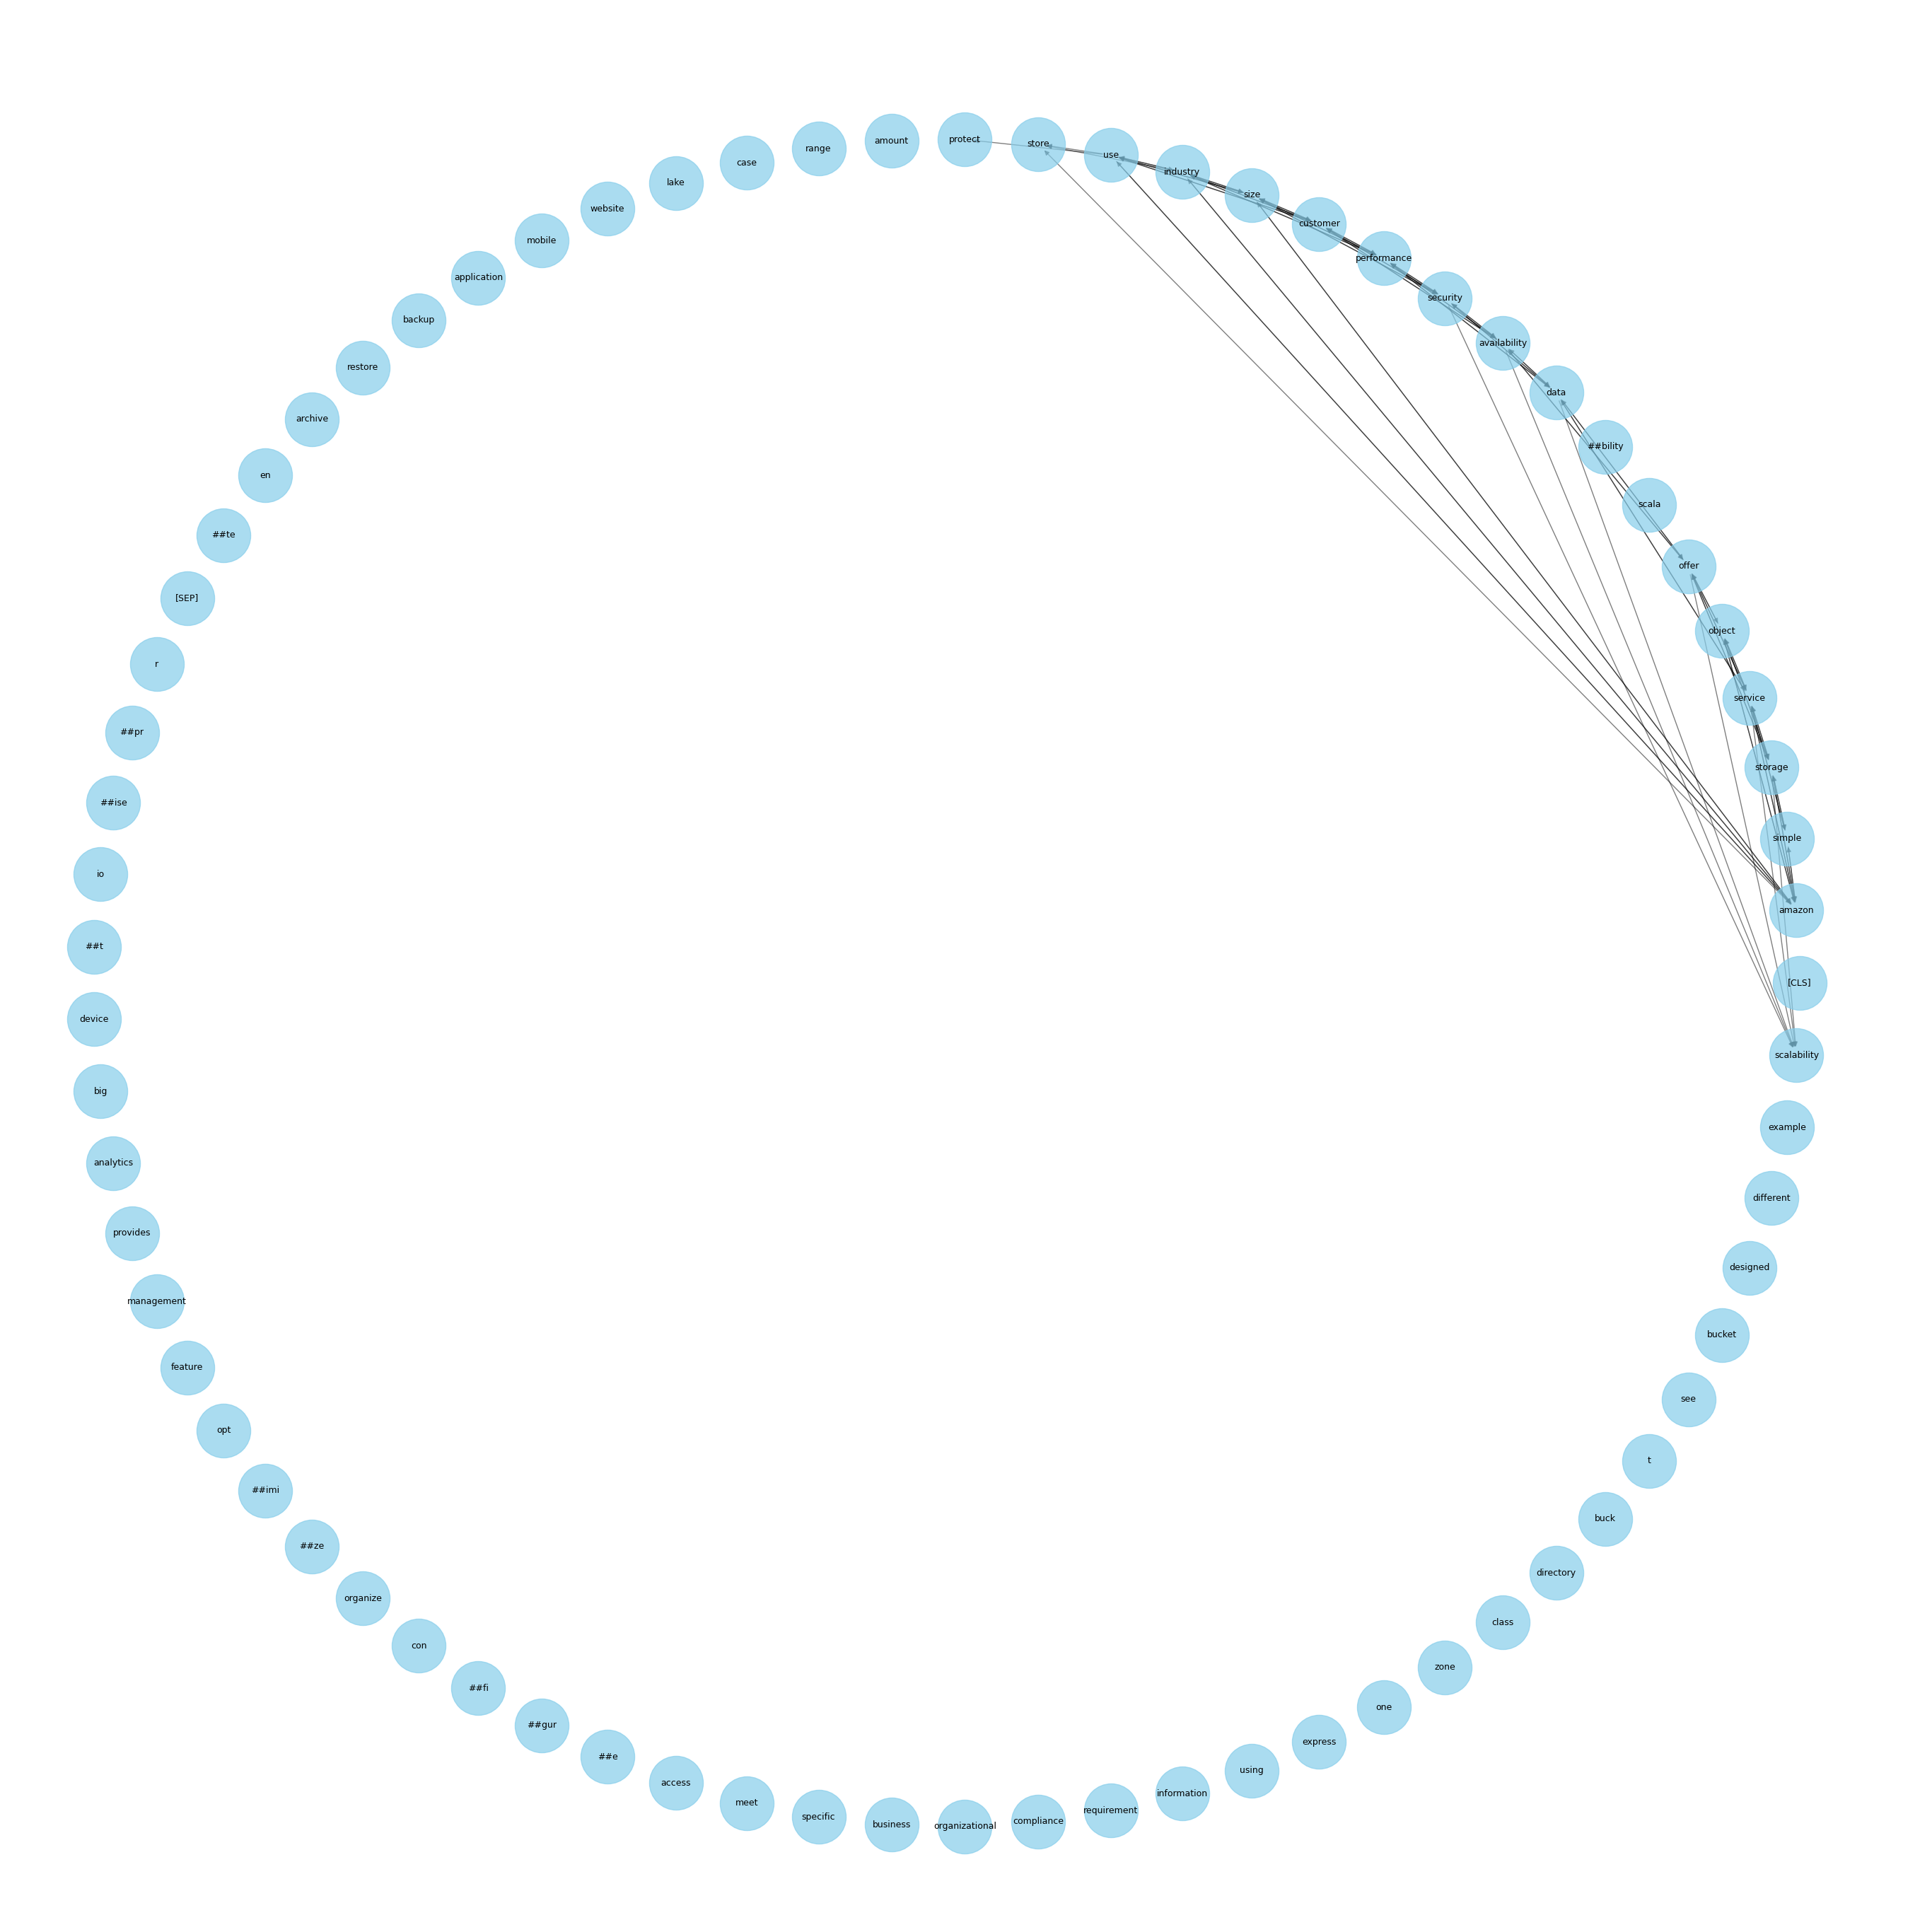


--------- KNOWLEDGE GRAPH RESULTS ---------
Knowledge Graph -  DiGraph with 73 nodes and 82 edges

--------- KNOWLEDGE GRAPH RESULTS ---------


--------- ACCURACY, QUALITY & RELEVANCE RESULTS ---------
Accuracy -  0.0
Quality -  1.0
Relevance -  1.0

--------- ACCURACY, QUALITY & RELEVANCE RESULTS ---------



In [24]:
# Main script
if __name__ == "__main__":
    # Step 1: Extract text from the AWS documentation URL (limited to the first 10 lines)
    aws_url = "https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html"
    text_content = extract_text_from_url(aws_url)

    gc.collect()

    # Step 2: Preprocess the text
    preprocessed_text = preprocess_text(text_content)
    print("\n--------- PRE-PROCESSED TEXT RESULTS ---------")
    print("preprocessed_text - ", preprocessed_text)
    print("--------- PRE-PROCESSED TEXT RESULTS ---------\n")

    # Clear text_content to free up memory
    del text_content
    gc.collect()

    # Step 3: Perform Named Entity Recognition (NER)
    entities = ner_extraction(preprocessed_text)
    print("\n--------- NER RESULTS ---------")
    print("entities - ", entities)  # Limiting processed entities for demonstration

    gc.collect()

    # Step 4: Identify Relationships between Entities
    relationships = identify_relationships(preprocessed_text.split(), entities)
    print("relationships - ", relationships)
    print("--------- NER RESULTS ---------\n")

    gc.collect()

    # Clear preprocessed_text to free up memory
    del preprocessed_text
    gc.collect()

    # Step 5: Generate insert queries
    insert_queries = generate_insert_queries(entities, relationships)

    # Step 6: Plot the knowledge graph
    knowledge_graph = construct_knowledge_graph(entities, relationships, insert_queries)
    print("\n--------- KNOWLEDGE GRAPH RESULTS ---------")
    print("Knowledge Graph - ", knowledge_graph)
    print("\n--------- KNOWLEDGE GRAPH RESULTS ---------\n")

    gc.collect()

    # Step 7: Calculation of Accuracy, Quality and Relevance
    accuracy, quality, relevance = calculate_accuracy_quality_relevance(entities, relationships)
    print("\n--------- ACCURACY, QUALITY & RELEVANCE RESULTS ---------")
    print("Accuracy - ", accuracy)
    print("Quality - ", quality)
    print("Relevance - ", relevance)
    print("\n--------- ACCURACY, QUALITY & RELEVANCE RESULTS ---------\n")